In [52]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import math as mth
import scipy.stats as st
import re
import warnings
warnings.filterwarnings(action='ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import colorama
from colorama import Style
from colorama import Fore

<div style="border:solid green 2px; padding: 20px">

## Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Описание данных

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Содержание
* [Предобработка и изучение данных](#chapter1)
* [Построение воронки событий](#chapter2)
* [Анализ результатов A/A/B-теста](#chapter3)
* [Общие выводы](#chapter4)

## Предобработка и изучение данных  <a class ="anchor" id="chapter1"></a>

In [2]:
try:
    df=pd.read_csv('/Users/vadimhlebnikov/Downloads/logs_exp.csv',sep='\t')

except:
    df=pd.read_csv('/datasets/logs_exp.csv',sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
#пропусков нет
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [5]:
#дубликаты есть
df.duplicated().sum()

413

In [6]:
#удаляем дубликаты
df = df.drop_duplicates()

In [7]:
#приведем названия колонок с "змеиному" формату
df.columns = ['event_name','device_id_hash','event_timestamp','exp_id']

In [8]:
#неявных дубликатов или некорректных значений в столбце event_name нет
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [9]:
#неявных дубликатов или некорректных значений в столбце exp_id нет
df['exp_id'].unique()

array([246, 248, 247])

In [10]:
#создадим столбец с датой и временем и датой
df['date_time'] = pd.to_datetime(df['event_timestamp'],unit='s')
df['date'] = df['date_time'].dt.date
df

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [11]:
#Проверим есть ли в двух группах одни и те же пользователи

g246 = df.query('exp_id == 246')
g247 = df.query('exp_id == 247')
g248 = df.query('exp_id == 248')

print('Количество пересечений по пользователям меду между 246 и 247 группами: ', g246['device_id_hash'].isin(g247['device_id_hash']).sum())
print('Количество пересечений по пользователям меду между 247 и 248 группами: ', g247['device_id_hash'].isin(g248['device_id_hash']).sum())
print('Количество пересечений по пользователям меду между 246 и 248 группами: ', g246['device_id_hash'].isin(g248['device_id_hash']).sum())

Количество пересечений по пользователям меду между 246 и 247 группами:  0
Количество пересечений по пользователям меду между 247 и 248 группами:  0
Количество пересечений по пользователям меду между 246 и 248 группами:  0


Пересечений по id пользователей между группами не выявлено. Разбиение по группам в этой части проведено корректно.

In [12]:
# Рассмотрим данные лога
len_df = len(df)
events = df['event_name'].nunique()
print(f'В логе отражается {events} видов событий. В общей сложности зафиксировано {len(df)} событий.') 

В логе отражается 5 видов событий. В общей сложности зафиксировано 243713 событий.


In [13]:
#В логе отражается пять видов событий
unique_users = df['device_id_hash'].nunique()
print(f'В логе содержится информация о {unique_users} пользователях.') 


В логе содержится информация о 7551 пользователях.


In [14]:
mean_event_number = df.groupby('device_id_hash').count()['event_name'].mean()
median_event_number = df.groupby('device_id_hash').count()['event_name'].median()
print(f'В среднем на одного пользователя приходится {mean_event_number:.1f} событий.') 
print(f'Медианное значение: {median_event_number:.1f} событий.')

В среднем на одного пользователя приходится 32.3 событий.
Медианное значение: 20.0 событий.


In [15]:
min_date = df['date_time'].min()
max_date = df['date_time'].max()
print(f'В датафрейме приводятся данные во временном промежутке с {min_date} до {max_date}.')

В датафрейме приводятся данные во временном промежутке с 2019-07-25 04:43:36 до 2019-08-07 21:15:17.


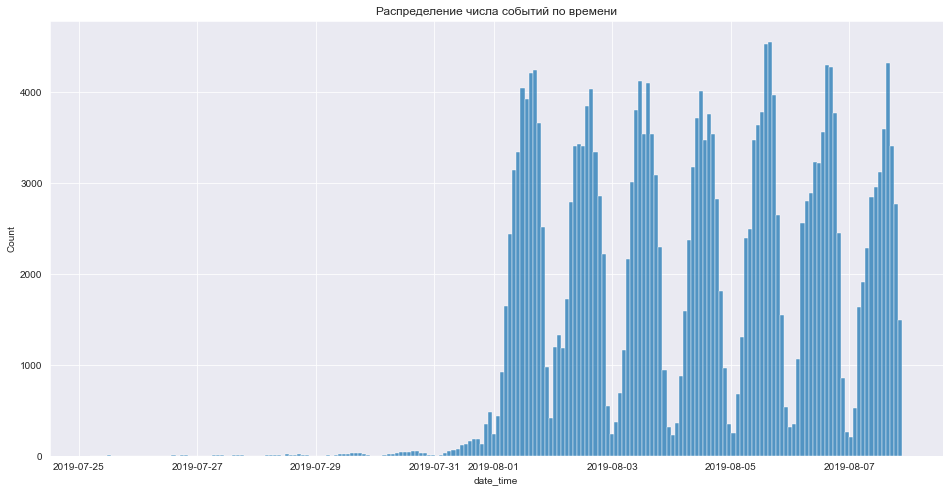

In [16]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
ax = sns.histplot(df['date_time'],bins=200)
plt.title('Распределение числа событий по времени')
plt.show()

In [17]:
df.groupby('date').count()['event_name'].head(20)

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_name, dtype: int64

Данные до 1 августа явно являются неполными. Их необходимо убрать из датафрейма.

In [18]:
#Отрезаем дынные до 1 августа
df = df.query("date_time >= '2019-08-1'")

In [19]:
#Считаем потери
new_len_df = len(df)
new_unique_users = df['device_id_hash'].nunique()
lost_data_events = len_df-new_len_df
lost_data_events_ratio = (len_df-new_len_df)/len_df
lost_data_users = unique_users - new_unique_users
lost_data_users_ratio = (unique_users - new_unique_users) / unique_users
print(f'После отрезания неполных данных было утрачено {lost_data_events} записей о событиях.')
print(f'В относительном выражении {lost_data_events_ratio:.5f} объема записей о событиях.')
print(f'После отрезания неполных данных были утрачены данные {lost_data_users} пользователей.')
print(f'В относительном выражении {lost_data_users_ratio:.5f} от общего объема пользователей.')

После отрезания неполных данных было утрачено 2826 записей о событиях.
В относительном выражении 0.01160 объема записей о событиях.
После отрезания неполных данных были утрачены данные 17 пользователей.
В относительном выражении 0.00225 от общего объема пользователей.


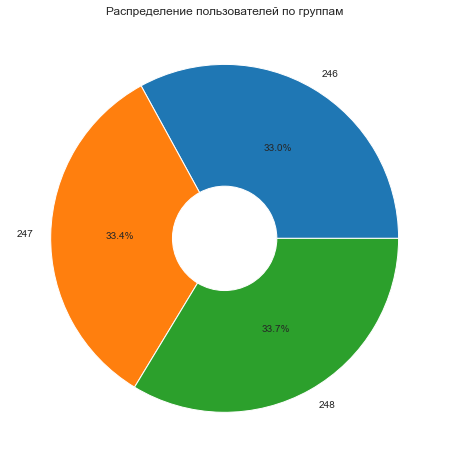

In [34]:
#Построим диаграмму распределения пользователей по группам
exp_groups = df.groupby('exp_id').nunique()['device_id_hash']
plt.figure(figsize=(16,8))
labels2 = ['246', '247','248']
colors = sns.color_palette()
ax=plt.pie(exp_groups, labels = labels2, colors = colors, autopct='%.1f%%',wedgeprops=dict(width=0.7))
plt.title('Распределение пользователей по группам')
plt.show()

Данные не содержат пропусков. В процессе предобработки был удален сравнительно небольшой объем явных дубликатов. Неявных дубликатов не выявлено. Данные очищены от ранних, предположительно, случайных значений до 1 августа 2019 года. Потеряно порядка 1,2% записей, что является в данном случае допустимым. 

В логе отражается 5 видов событий. В общей сложности зафиксировано 243713 событий. В логе содержится информация о 7551 пользователях. **В среднем на одного пользователя приходится 31.9 событий. Медианное значение: 19.0 событий**.

**В наборе остались записи из всех трех групп теста в примерно равных пропорциях**. 

## Построение воронки событий  <a class ="anchor" id="chapter2"></a>

In [21]:
#строим воронку событий и выявляем встречаемость событий
funnel = (
df.groupby('event_name').count()['device_id_hash']
    .reset_index()
    .sort_values('device_id_hash', ascending = False)
)
funnel

,event_name,device_id_hash
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [36]:
funnel_event = (
df.groupby('event_name').nunique()['device_id_hash']
    .reset_index()
    .sort_values('device_id_hash', ascending = False)
)
funnel_event

,event_name,device_id_hash
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [23]:
#добавляем долю от всех пользователей, совершивших событие хотя бы раз
funnel_event['share'] = funnel_event['device_id_hash'] / df['device_id_hash'].nunique()
funnel_event

,event_name,device_id_hash,share
1,MainScreenAppear,7419,0.985
2,OffersScreenAppear,4593,0.610
0,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


Судя по воронке событий, они происходят в следующем порядке: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful. Событие Tutorial выглядит лишним в этой воронке. Его можно исключить из анализа.
    

In [24]:
funnel_event = funnel_event.query('event_name != "Tutorial"')
df = df.query('event_name != "Tutorial"')

In [51]:
#Строим воронку событий

fig = px.funnel(funnel_event, x=funnel_event['device_id_hash'], y=funnel_event['event_name'],  title='Воронка событий')
fig.show()

In [26]:
#Добавляем колонку с конверсией в следующий шаг
funnel_event['share_step'] = funnel_event['device_id_hash'] / funnel_event['device_id_hash'].shift()
funnel_event = funnel_event.reset_index(drop=True)
funnel_event

,event_name,device_id_hash,share,share_step
0,MainScreenAppear,7419,0.985,NaN
1,OffersScreenAppear,4593,0.610,0.619
2,CartScreenAppear,3734,0.496,0.813
3,PaymentScreenSuccessful,3539,0.470,0.948


**Максимальная потеря пользователей происходит на этапе предложения оффера. До него не доходит 38% пользователей, открывших главный экран приложения**. При переходе от офера к корзине теряется еще 19% пользователей. Потери при переходе от корзины к экрану успешной оплаты сравнительно невелики и составляют порядка 5%. **До этапа успешной оплаты доходят 47% пользователей приложения в анализируемом периоде**. 

## Анализ результатов A/A/B-теста <a class ="anchor" id="chapter4"></a>

In [27]:
#рассчитаем абсолютный и относительный размер групп тестирования

groups = df.groupby('exp_id').nunique()['device_id_hash'].reset_index()

groups['share'] = groups ['device_id_hash'] / groups ['device_id_hash'].sum()

groups

,exp_id,device_id_hash,share
0,246,2483,0.330
1,247,2512,0.334
2,248,2535,0.337


Размеры групп примерно развны и соствляют 2,5 тыс. пользователей или 33-34% от общего числа юзеров.

In [28]:
group_pivot = pd.pivot_table(df, values = 'device_id_hash', index='event_name',columns='exp_id',aggfunc='nunique')
group_pivot = group_pivot.sort_values(246,ascending=False)
group_pivot

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


Самое популярное событие - показ главного экрана (MainScreenAppear). Оно лидирует примерно с одинаковым отрывом во всех группах. Рассчитаем статистическую достоверность отличий доли этого события по группам, а также других событий с помощью функции.

In [29]:
#Сформируем списки для статистических тестов

list_246 = group_pivot[246].to_list() 
sum_246 = sum(list_246)
list_247 = group_pivot[247].to_list() 
sum_247 = sum(list_247)
event_list = group_pivot.index.to_list()

При проверке гипотез о равенстве долей традиционно применяют z-тест. В нашем случае выборки достаточно велики и нет оснований полагать, что они зависимы. Поэтому применим именно данный вид теста.

Сформулируем нулевую и альтернативные гипотезы для статистических тестов по разнице конверсий в воронке событий:

*H0: Доли пользователей, совершивших событие в группах, равны*. 

*H1: Доли пользователей, совершивших событие в группах, не равны*. 
    

In [30]:
#пишем функцию для проверки равенства долей без поправки Бонферрони

def comp_func (list1,sum1,list2,sum2,event_list):
    for i in range (0,len(list_246)):
        a_trials = sum1
        b_trials = sum2
        a_succeses = list1[i]
        b_succeses = list2[i]
    
        alpha = 0.05  
        p1 = a_succeses/a_trials
        p2 = b_succeses/b_trials
        p_combined = (a_succeses + b_succeses)/ (a_trials + b_trials)
        difference = p1 - p2 

        z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / a_trials + 1 / b_trials))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(Fore.BLUE + Style.BRIGHT + event_list[i] + Style.RESET_ALL, 'p-значение: ', p_value) 
    
        if p_value < alpha:
            print(Fore.GREEN + Style.BRIGHT + 'Отвергаем нулевую гипотезу: между долями есть значимая разница' + Style.RESET_ALL)
        else:
            print(Fore.RED + Style.BRIGHT +
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'+ Style.RESET_ALL) 

In [53]:
#применяем функцию к данным групп 246 и 247 (A/A группы)
comp_func(list_246,sum_246,list_247,sum_247,event_list)

MainScreenAppear p-значение:  0.35195027387494493
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear p-значение:  0.8966517949162409
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear p-значение:  0.7359876852552283
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful p-значение:  0.4957537491808677
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Согласно результатам z-теста, разница в конверсиях при указанных размерах выборок недостаточна, чтобы отвергать нулевые гипотезы о равенстве долей достижения пользователями одного из четырех важных событий. Разбиение на группы было проведено корректно.

In [ ]:
#Добавляем данные по 248-ой группе.
list_248 = group_pivot[248].to_list() 
sum_248 = sum(list_248)


In [ ]:
#Проводим сравнение данных по группам 246 (контрольная) и 248 (с изменениями)
comp_func(list_246,sum_246,list_248,sum_248,event_list)

По всем событиям значение p-value значительно больше 0.05, а значит **говорить об отличии в конверсии в группе 246 и группе 248 нельзя**.

In [ ]:
#Проводим сравнение данных по группам 247 (контрольная) и 248 (с изменениями)

comp_func(list_247,sum_247,list_248,sum_248,event_list)

По всем событиям значение p-value значительно больше 0.05, а значит **говорить об отличии в конверсии в группе 247 и группе 248 нельзя**.

In [ ]:
#Складываем данные по двум контрльным группам (246 и 247)
list_246_247 = [x+y for x,y in zip(list_246,list_247)] 
sum_246_247 = sum(list_246_247)

In [ ]:
comp_func(list_246_247,sum_246_247,list_248,sum_248,event_list)

По всем событиям значение p-value значительно больше 0.05, а значит **говорить об отличии в конверсии в объединенных контрольных группах (246 и 247) и группе 248 нельзя**.

Выше было проведено 16 проверок гипотез при уровне статистической значимости 0.05. Теперь добавим в фунцию расчета корректировку Бонферрони, уменьшающую значение альфа пропорционально числу тестов. Таким уровень статистической значимости пудет снижен до 0.003125.

In [ ]:
def comp_func (list1,sum1,list2,sum2,event_list):
    for i in range (0,len(list_246)):
        a_trials = sum1
        b_trials = sum2
        a_succeses = list1[i]
        b_succeses = list2[i]
    
        alpha = 0.05  
        p1 = a_succeses/a_trials
        p2 = b_succeses/b_trials
        p_combined = (a_succeses + b_succeses)/ (a_trials + b_trials)
        difference = p1 - p2 

        z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / a_trials + 1 / b_trials))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(Fore.BLUE + Style.BRIGHT + event_list[i] + Style.RESET_ALL, 'p-значение: ', p_value) 
    
        if p_value < alpha/16:
            print(Fore.GREEN + Style.BRIGHT + 'Отвергаем нулевую гипотезу: между долями есть значимая разница' + Style.RESET_ALL)
        else:
            print(Fore.RED + Style.BRIGHT +
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'+ Style.RESET_ALL)

In [ ]:
#Повторим проведенные ранее сравнения с учетом корректировки 
comp_func(list_246,sum_246,list_247,sum_247,event_list)


In [ ]:
comp_func(list_246,sum_246,list_248,sum_248,event_list)

In [ ]:
comp_func(list_247,sum_247,list_248,sum_248,event_list)

In [ ]:
comp_func(list_246_247,sum_246_247,list_248,sum_248,event_list)

С учетом поправки и значительного снижения уровня значимости тесты показывают, что в различиях между тестовой и контрольной группами статистически значимой разницы нет.

## Общие выводы  <a class ="anchor" id="chapter5"></a>

1. Данные не содержат пропусков. В процессе предобработки был удален сравнительно небольшой объем явных дубликатов. Неявных дубликатов не выявлено. Данные очищены от ранних, предположительно, случайных значений до 1 августа 2019 года. Потеряно порядка 1,2% записей, что является в данном случае допустимым.


2. **В логе отражается 5 видов событий. В общей сложности зафиксировано 243713 событий и 7551 пользователь. В среднем на одного пользователя приходится 31.9 событий. Медианное значение: 19.0 событий. В наборе остались записи из всех трех групп теста в примерно равных пропорциях**.


3. **Максимальная потеря пользователей происходит на этапе предложения оффера**. До него не доходит 38% пользователей, открывших главный экран приложения. При переходе от оффера к корзине теряется еще 19% пользователей. Потери при переходе от корзины к экрану успешной оплаты сравнительно невелики и составляют порядка 5%. **До этапа успешной оплаты доходят 47% пользователей приложения в анализируемом периоде**.


4. Пересечений по id пользователей между группами не выявлено. Разбиение по группам в этой части проведено корректно.


5. Проведено 4 группы тестов: A/A, A1/B, A2/B и A1+A2/B (по тесту на каждый вид события). Все они покаали отсутствие статистически значимой разницы между группами. ***Значит новые шрифты приложения не влияют на конверсию и в их имплементации нет нужды***.


6. Для корректировки результатов тестов была применена поправка Бонферрони и уровень значимости снижен до 0.003125. Она не повлияла на результаты теста. **Значение p-value в тестах очень высоко, что говорит о минимальной вероятности положительного влияния на конверсию от изменения шрифтов в приложении**.

